In [97]:
# Classical data science toolbox
import pandas as pd
import numpy as np
# Module specific packages
from scripts import data
# Plotting packages
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
# For missing value analysis
import missingno as mno
# Datetime handling
import datetime as dt

In [87]:
# Get data dictionary
data_dict = data.get_data_dict()
# And store in separate data-frames
purchases = data_dict['purchases']
users = data_dict['users']

# Fix dates
purchases['purchased_at'] = pd.to_datetime(purchases.purchased_at)
users['created_at'] = pd.to_datetime(users.created_at)

### Purchase analysis
In the case of purchases, we focus on:
- Possible outliers,
- Dates beyond current year and month
- Which products have been sold the most, and
- Correlation between the time when the item was bought, and the correlation between buying product1 and product2.

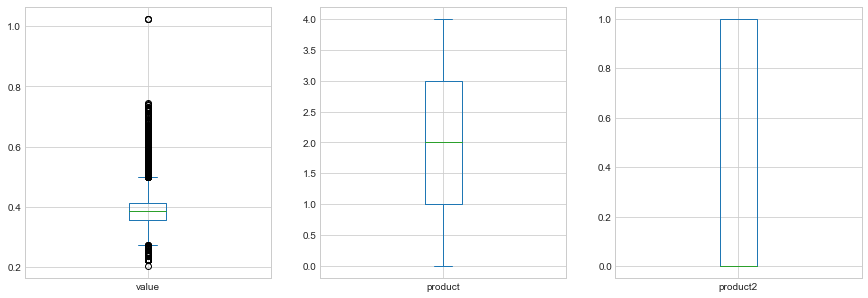

In [88]:
# Look for possible outliers
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5))
for n, col in enumerate(purchases.drop(['user_id', 'purchased_at'], axis = 1).columns) :
    purchases[col].plot.box(
        ax = axes[n]
    )
plt.show()

No outliers have been found.

In [89]:
purchases.purchased_at.max(), purchases.purchased_at.min()

(Timestamp('2021-08-11 18:20:29'), Timestamp('2017-08-12 19:02:07'))

As it can be seen above, purchased_at moves within a reasonable range.

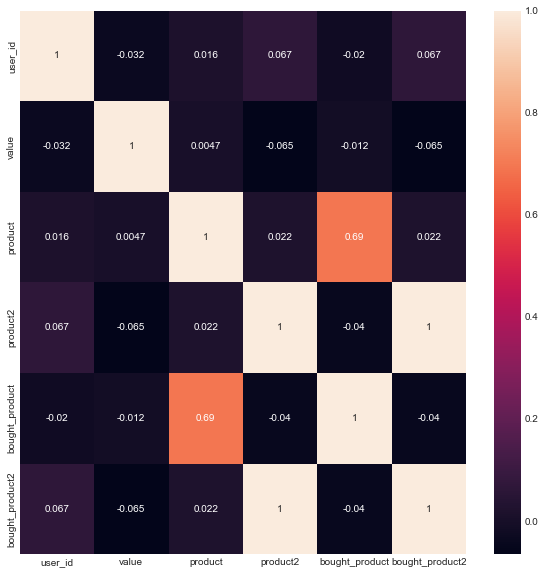

In [90]:
# Make columns if bought
purchases['bought_product'] = purchases['product'].astype(bool).astype(int)
purchases['bought_product2'] = purchases['product2'].astype(bool).astype(int)
# Plot correlations
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(
    purchases.corr('pearson'),
    annot = True,
    ax = ax
)
plt.show()

The pearson correlation coefficients are too low to reach any conclusions.

### Users analysis
Here, we can
- Fix birthyears/created_at that are either prior to 1930, and beyound current year and month.
    - In the first case, simply replace by "NaN".
    - In the second one, drop.
- Nunique values in each column
- Analyze missing values -- correlation and quantities.

In [91]:
# Print min and max of created_at column
print(users.created_at.min(), users.created_at.max())
# Replace weird values by NaN
users.loc[
    (users.created_at.dt.date >= dt.date.today()) | (users.created_at.dt.date < dt.date(year = 1930, month = 1, day = 1)),
    'created_at'
] = np.nan

2016-08-12 19:22:29 2031-07-05 11:57:35


It is impossible that an account was created after the current day and month, so those are replaced by NaN values. Similarly for the birthyear, the missing values are filled as follows:

In [95]:
users.loc[
    # A user should have less than 100 years...and more than 16
    (users.birthyear <= 1915) | (users.birthyear >= 2006),
    'birthyear'
] = np.nan

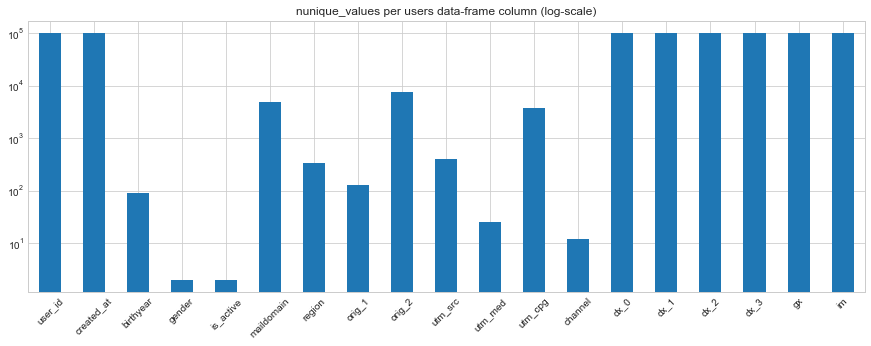

In [135]:
users.nunique().plot.bar(
    logy = True,
    figsize = (15, 5),
    rot = 45,
    title = 'nunique_values per users data-frame column (log-scale)'
)
plt.show()

Finally, analyze missing values

<AxesSubplot:>

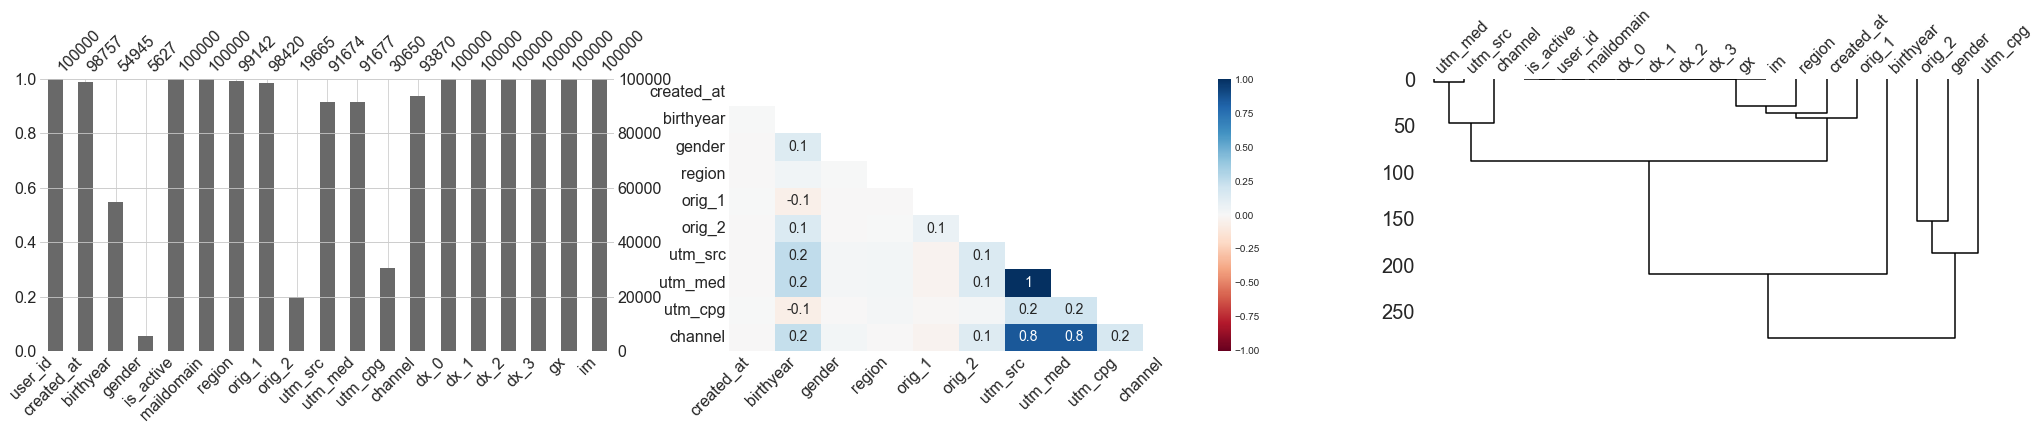

In [136]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (35, 5))
mno.bar(users, ax = axes[0])
mno.heatmap(users, ax = axes[1])
mno.dendrogram(users, ax = axes[2])

From here it is observed that:
1. The gender is almost never revealed.
2. Origin_2 is also missing in most occasions.
3. utm_cpg is missing in most cases.
4. utm_src and utm_med are missing in the exact same cases.